# SHAP analysis of RANDM thermospheric density model
This notebook is one companion piece to Bard, Murphy, Halford (2025): "Elucidating the Grey Atmosphere: SHAP Value Analysis of a Random Forest Atmospheric Neutral Density Model".

## Part B: Macroscle SHAP Analysis

This notebook uses the saved SHAP explanations from Part A to generate the plots shown in the paper, here Figures 1-4.

#### Requirements
- numpy
- pandas
- matplotlib
- fasttreeshap
- shap

#### References
- SHAP paper (arxiv link)
- saved SHAP explanations (`./SHAP_values/`)
- Murphy+2025 (RANDM model paper): https://doi.org/10.1029/2024SW003928
- MLTDM repository: https://github.com/kylermurphy/mltdm/

In [1]:
import numpy as np
import numpy.random as rand
import pandas as pd
import time as pytime
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
import fasttreeshap as fts
from fasttreeshap.plots import beeswarm, waterfall, bar
import shap

In [3]:
# hack to save and load minimal viable explanation, 
# since it takes a while to make
def save_explanation(fname, expln):
    # hack to avoid pickling and associated errors
    dta = expln.data.astype(float)
    np.savez(fname, values=expln.values, 
             base_values=expln.base_values, data=dta,
             feature_names=expln.feature_names, 
             output_names=expln.output_names, compute_time=expln.compute_time)

def load_explanation(fname):
    dat_dict = np.load(fname)
    return fts.Explanation(values = dat_dict["values"], base_values=dat_dict["base_values"], 
                           data=dat_dict["data"], feature_names=dat_dict["feature_names"], 
                           output_names=dat_dict["output_names"], 
                           compute_time=dat_dict["compute_time"])

# hack to blend multiple explanations together
def stack_expln(expln1, expln2):
    return fts.Explanation(values = np.vstack([expln1.values, expln2.values]), 
                             base_values = np.vstack([expln1.base_values, expln2.base_values]), 
                             data = np.vstack([expln1.data, expln2.data]),
                             feature_names=expln1.feature_names,
                            )

In [4]:
# functions to load feature data from hardcoded file
# Download file "FI_GEO_RF_data.h5" from Zenodo : https://zenodo.org/uploads/17201537

# data columns used in best-performing Murphy RF model
fgeo_col = ['1300_02', '43000_09', '85550_13', '94400_18', 'SYM_H index', 
            'AE', 'SatLat', 'cos_SatMagLT', 'sin_SatMagLT']

def _load_datafile(option: str = "test_d", path='./'):
    """
    Loads forest training/test data from CB's checkpointing of
    the train/test split in KM's Notebook (https://github.com/kylermurphy/mltdm/blob/main/Notebooks/RF_model.ipynb)

    option : str
        1. "test_d" : Grace B test data
        2. "train_d" : Grace B training data
        3. "oos_d" : Grace A
        4. "oos2_d" : CHAMP

    """

    return pd.read_hdf(path+"FI_GEO_RF_data.h5", option)


def load_data(storm: bool = None, option: str = "test_d", all_cols: bool = False, path='./'):
    """
    Loads pandas data array from file in `load_datafile`

    `storm` : bool | None
        1. None : load full data
        2. True : load storm data ("storm" == 1)
        3. False : load nonstorm data ("storm" == -1)

    option : str
        1. "test_d" : Grace B test data
        2. "train_d" : Grace B training data
        3. "oos_d" : Grace A
        4. "oos2_d" : CHAMP

    all_cols : bool
        If True, load all data columns
        If False, load just fgeo_columns used in best RF model

    path : str
        path to find FI_GEO_RF_data.h5 datafile, by default './'
    """

    dat = _load_datafile(option, path=path)

    if storm is not None:
        dat = dat[dat['storm'] == ((storm == True) - (storm == False))]

    return dat if all_cols else dat[fgeo_col]

In [5]:
# random sampler
NUM_SAMP = 2000
def sample(gen, df, num_samp=2000):
    """
    Samples df with num_samp points.

    gen: np.random.rand instance
        Used to generate random indices for sample selection
    df: pandas.dataframe
        data to sample
    num_samp : int
        number of points in sample
    """
    num_samp = min(num_samp, df.shape[0])
    ids = gen.choice(range(df.shape[0]), size = num_samp, replace=False)
    return df.iloc[ids]

#### load in SHAP explanations

In [6]:
# pre-calculated shap values stored in directory:
local_dir = './SHAP_values/'

In [7]:
storm_shap = load_explanation(local_dir+"storm1.npz")

In [8]:
recovery_shap = load_explanation(local_dir+"recovery1.npz")

In [9]:
quiet_shap = load_explanation(local_dir+"quiet1.npz")

In [10]:
mainphase_shap = load_explanation(local_dir+"mainphase1.npz")

In [11]:
total_shap = stack_expln(storm_shap, quiet_shap)

#### Figure 1 and other Bar plots

Figure 1 shows Feature importance across total sample with a dendogram showing hierarchial clustering based on feature redundancy analysis 

In [12]:
# redundancy analysis requires raw sample data
# we copy code from Part A (generateSHAP notebook)

In [13]:
full_data = load_data(all_cols=True, option="test_d", path='./') # loads Grace B test data

In [14]:
# sort into more specific datasets
storm_data = full_data[full_data['storm'] == 1]
quiet_data = full_data[full_data['storm'] == -1]

In [15]:
# random sampler
SEED = 693993
gen = rand.default_rng(SEED)

storm_samp_data = sample(gen, storm_data)
quiet_samp_data = sample(gen, quiet_data)

In [16]:
total_samp_data = pd.concat([storm_samp_data, quiet_samp_data])

In [17]:
tfirst = pytime.perf_counter()
total_clustering_xg = shap.utils.hclust(total_samp_data[fgeo_col].values, total_samp_data["400kmDensity_pred"].values, metric="auto")
tnow = pytime.perf_counter()
print(f"Time taken: {tnow - tfirst}")

Time taken: 0.8601325000054203


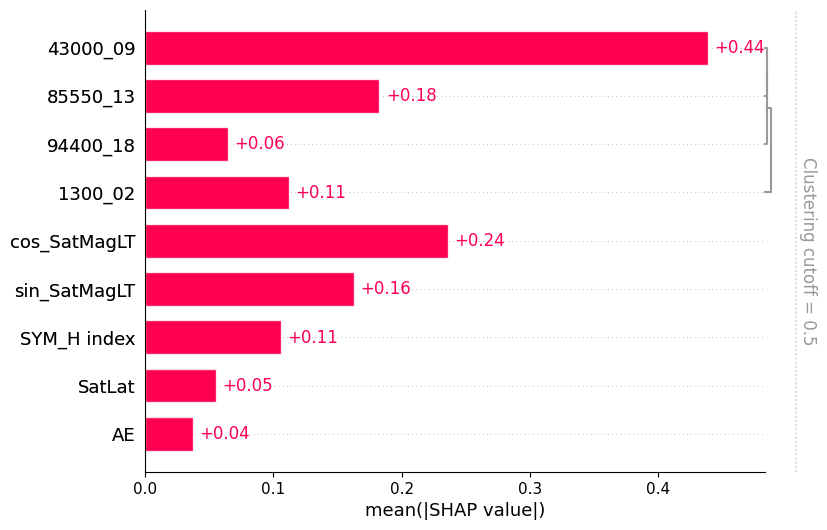

In [18]:
fts.plots.bar(total_shap, clustering=total_clustering_xg)

In [19]:
f = plt.gcf()
f.savefig("barTotal_clust_xg.png", bbox_inches="tight")
f.clf()

<Figure size 640x480 with 0 Axes>

In [148]:
# this is without hierarchial clustering
fts.plots.bar(total_shap)

In [149]:
f = plt.gcf()
f.savefig("barTotal.png", bbox_inches="tight")
f.clf()

##### other bar plots

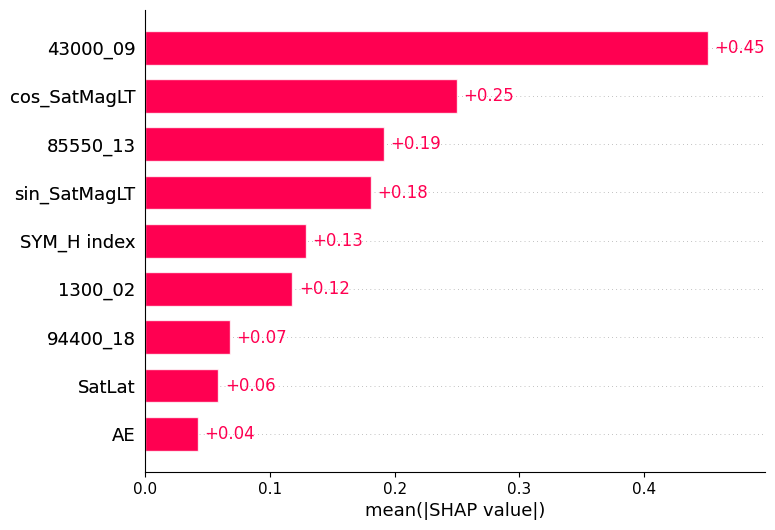

In [19]:
fts.plots.bar(storm_shap)

In [107]:
f = plt.gcf()
f.savefig("barStorm.png", bbox_inches="tight")
f.clf()

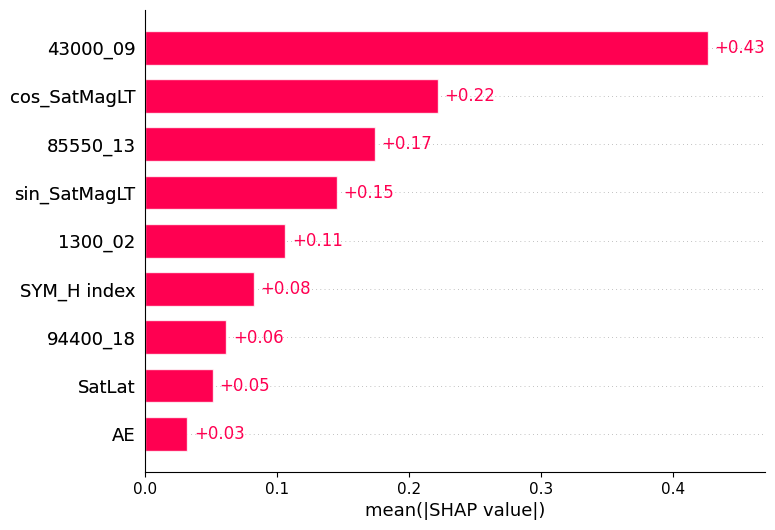

In [20]:
fts.plots.bar(quiet_shap)

In [109]:
f = plt.gcf()
f.savefig("barQuiet.png", bbox_inches="tight")
f.clf()

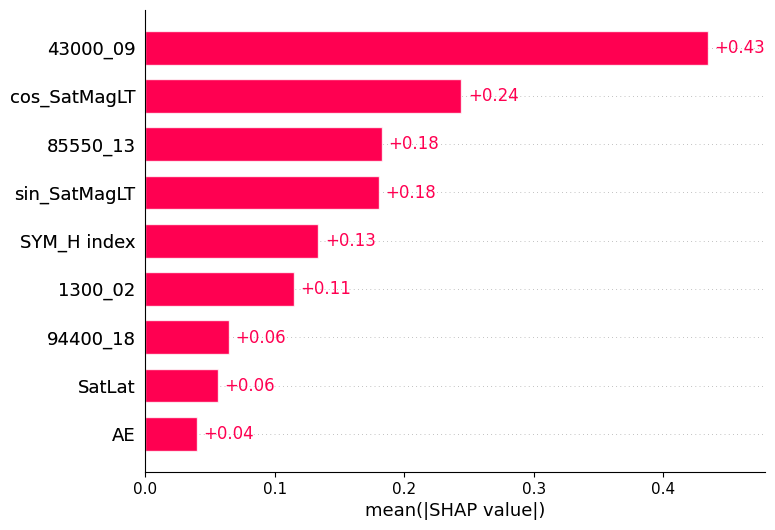

In [21]:
fts.plots.bar(recovery_shap)

In [216]:
f = plt.gcf()
f.savefig("barRecovery.png", bbox_inches="tight")
f.clf()

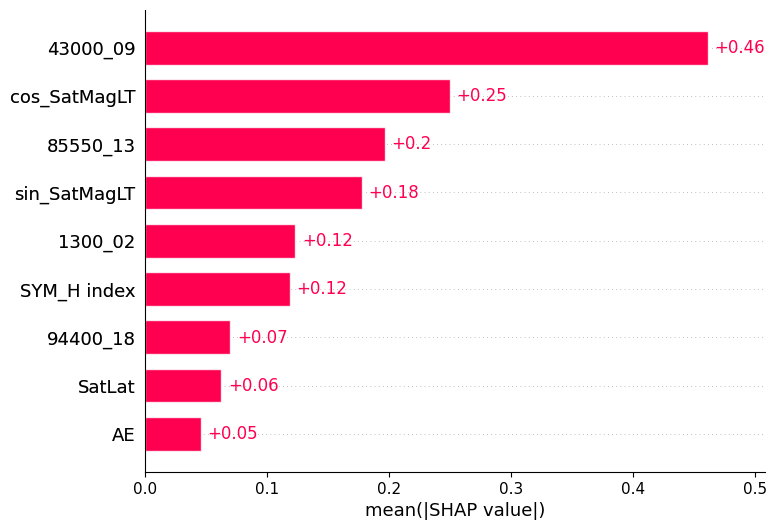

In [22]:
fts.plots.bar(mainphase_shap)

In [218]:
f = plt.gcf()
f.savefig("barMainPhase.png", bbox_inches="tight")
f.clf()

#### Figure 2 and other Beeswarm Plots

Total SHAP beeswarm is Figure 2 in the paper; beeswarm plots of the various subsamples are given here as well.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


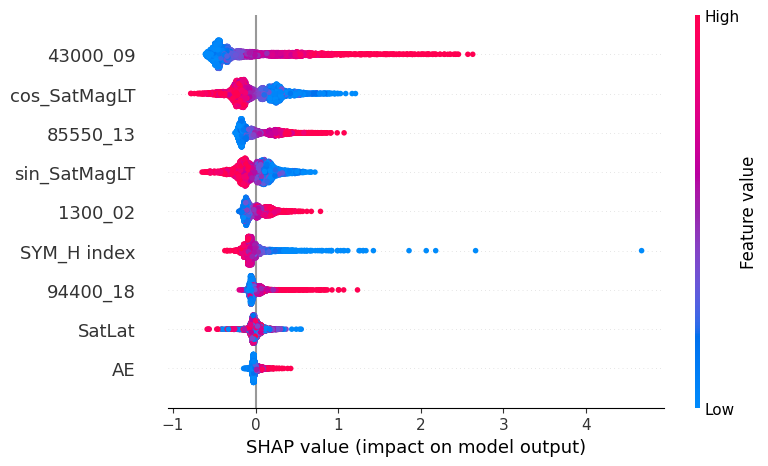

In [23]:
beeswarm(total_shap)

In [147]:
f = plt.gcf()
f.savefig("beeswarmTotal.png", bbox_inches="tight")
f.clf()

##### other beeswarm plots

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


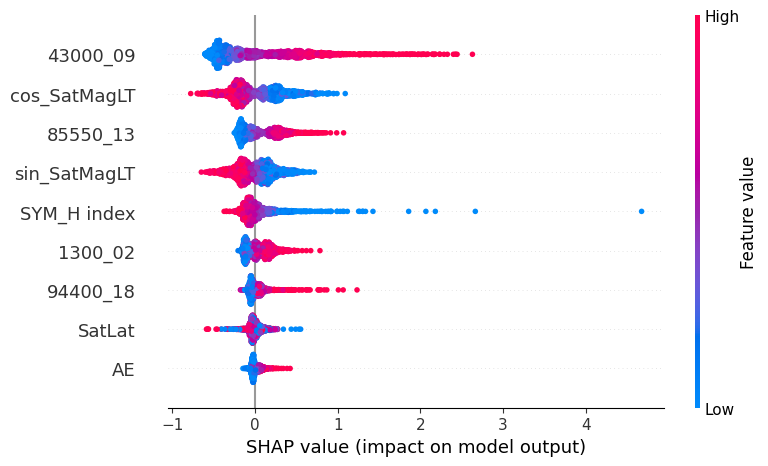

In [24]:
beeswarm(storm_shap)

In [18]:
f = plt.gcf()
f.savefig("beeswarmStorm.png", bbox_inches="tight")
f.clf()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


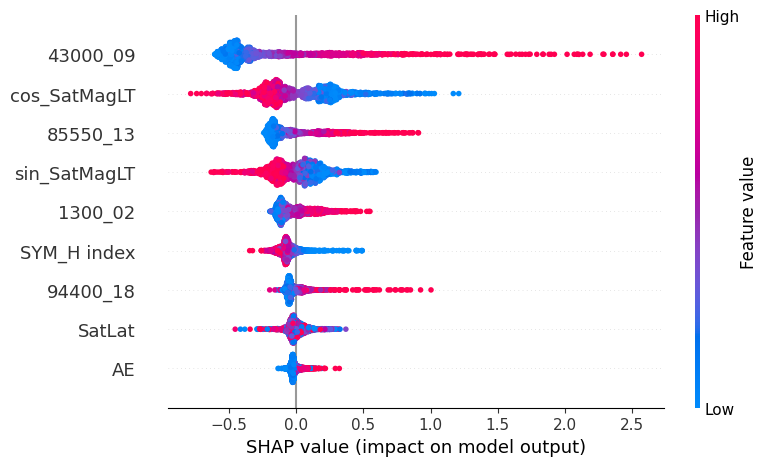

In [25]:
beeswarm(quiet_shap)

In [21]:
f = plt.gcf()
f.savefig("beeswarmQuiet.png", bbox_inches="tight")
f.clf()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


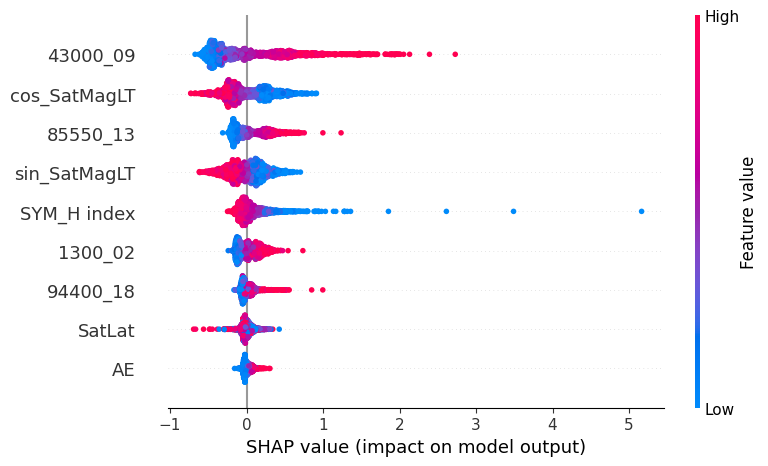

In [26]:
beeswarm(recovery_shap)

In [157]:
f = plt.gcf()
f.savefig("beeswarmRecover.png", bbox_inches="tight")
f.clf()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


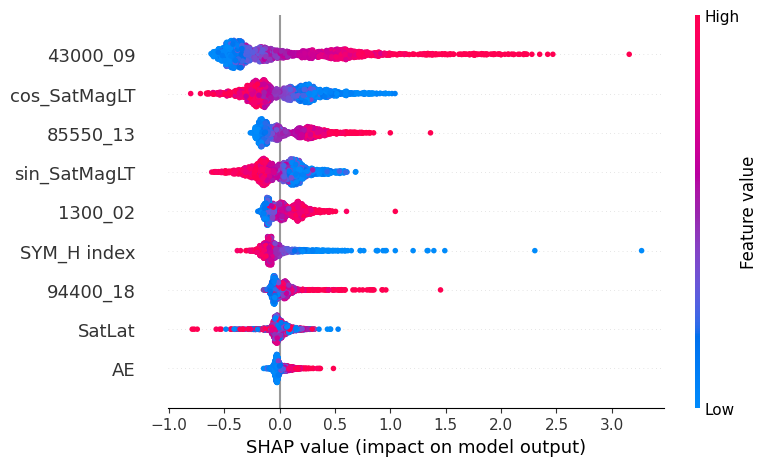

In [27]:
beeswarm(mainphase_shap)

In [159]:
f = plt.gcf()
f.savefig("beeswarmMainPhase.png", bbox_inches="tight")
f.clf()

#### Figure 3: Bar plots for SYM-H buckets
SHAP Bar plots for low, moderate and high SYM-H storms.

First, we load the appropriate SHAP explanations:

In [28]:
small_symH_shap = load_explanation(local_dir+"symHsml.npz")

In [29]:
mod_symH_shap = load_explanation(local_dir+"symHmod.npz")

In [30]:
large_symH_shap = load_explanation(local_dir+"symHlarge.npz")

##### SYM-H storm bar plots

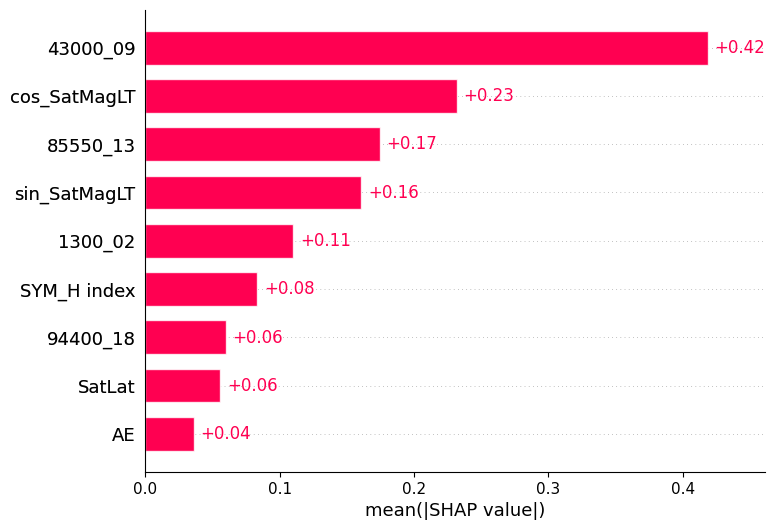

In [31]:
fts.plots.bar(small_symH_shap)

In [32]:
f = plt.gcf()
f.savefig("barSmlSYM.png", bbox_inches="tight")
f.clf()

<Figure size 640x480 with 0 Axes>

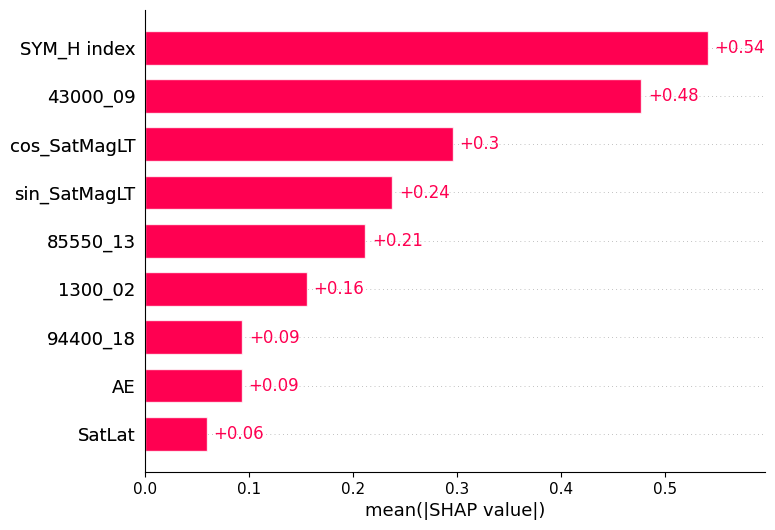

In [33]:
fts.plots.bar(mod_symH_shap)

In [70]:
f = plt.gcf()
f.savefig("barModSYM.png", bbox_inches="tight")
f.clf()

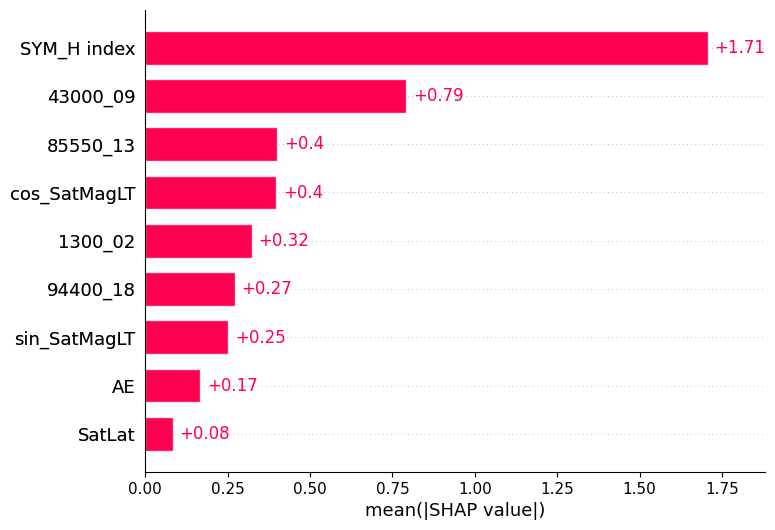

In [34]:
fts.plots.bar(large_symH_shap)

In [72]:
f = plt.gcf()
f.savefig("barLargeSYM.png", bbox_inches="tight")
f.clf()

#### Figure 4: SHAP values for SYM-H Bins

In [35]:
# load data
sym_h_bins = list(range(-20,-76,-5))
bn_shap = []
for i in range(len(sym_h_bins)-1):
    bn_shap.append(load_explanation(local_dir+f"sym_h_bin{sym_h_bins[i]}.npz"))

First, I plot the bar plots for each bin:

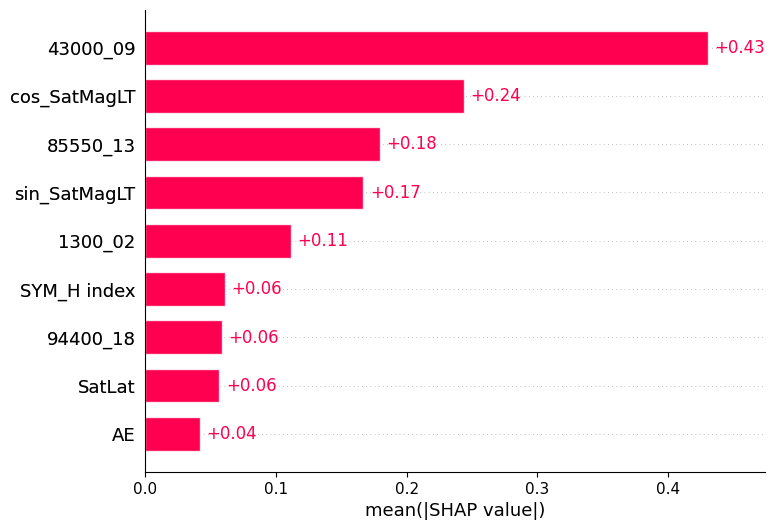

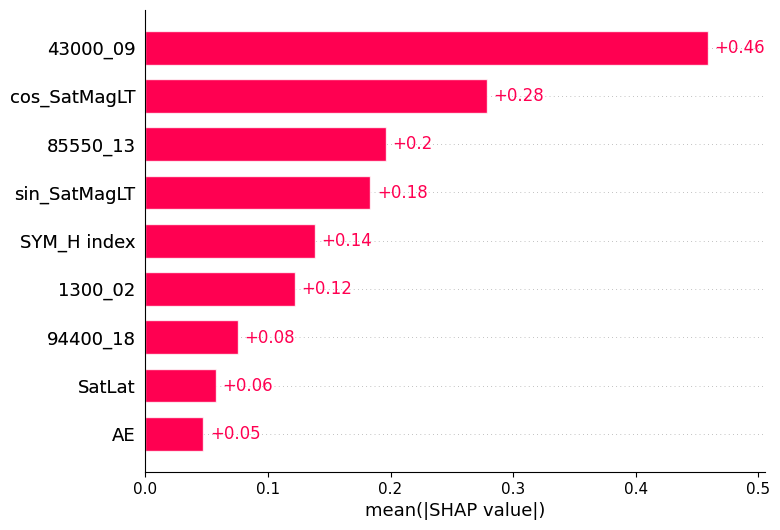

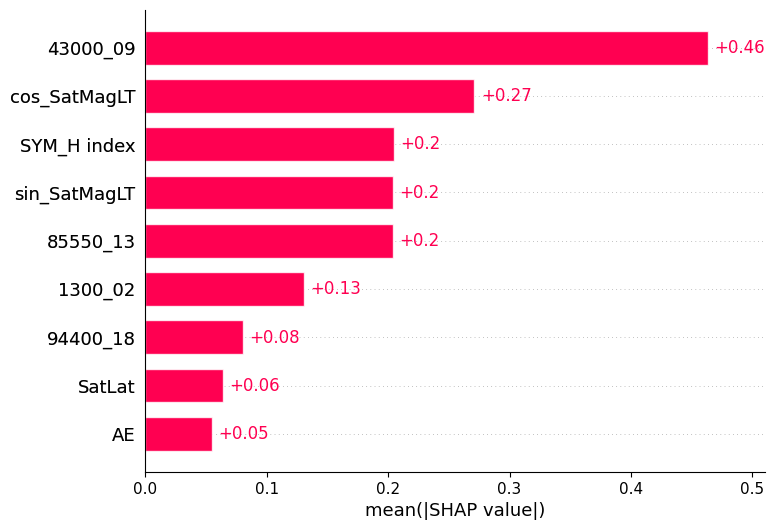

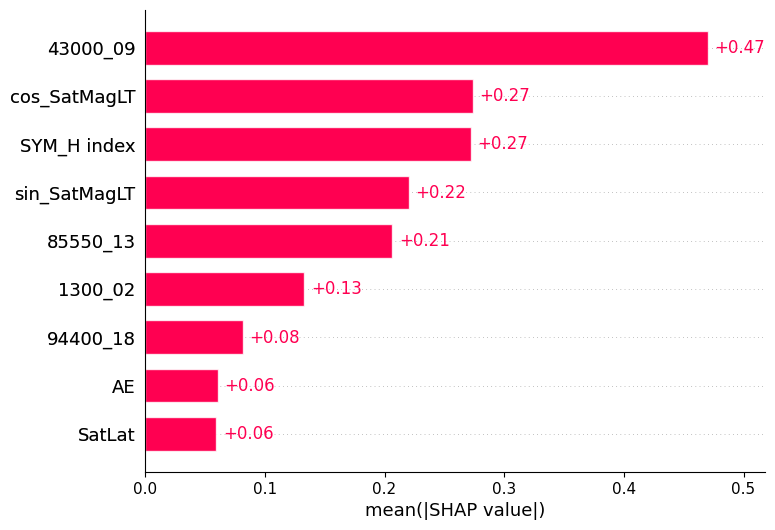

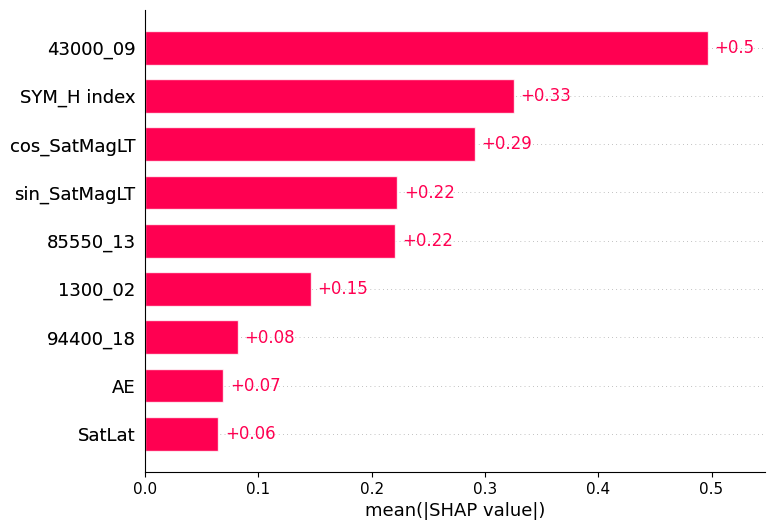

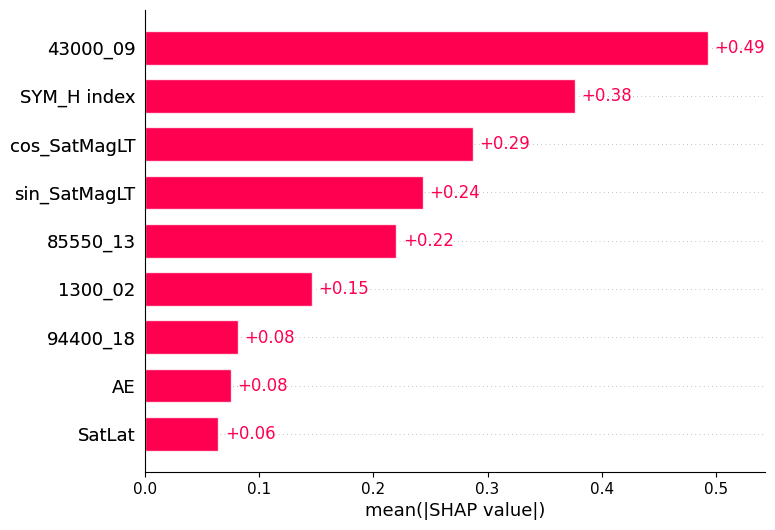

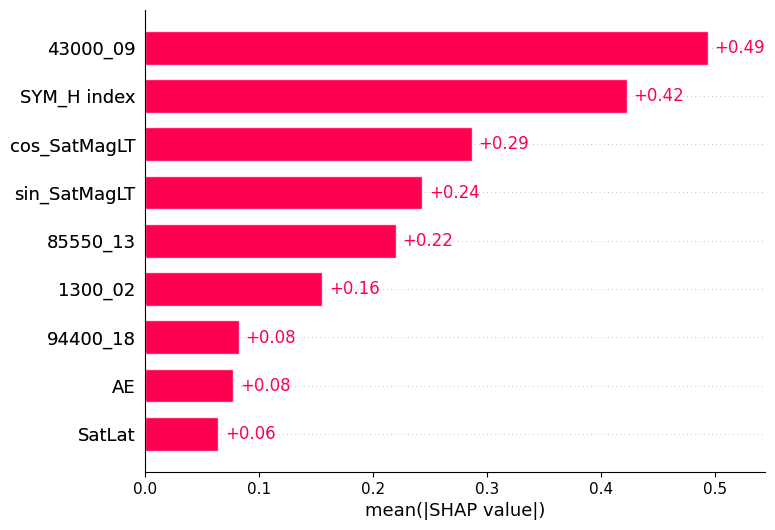

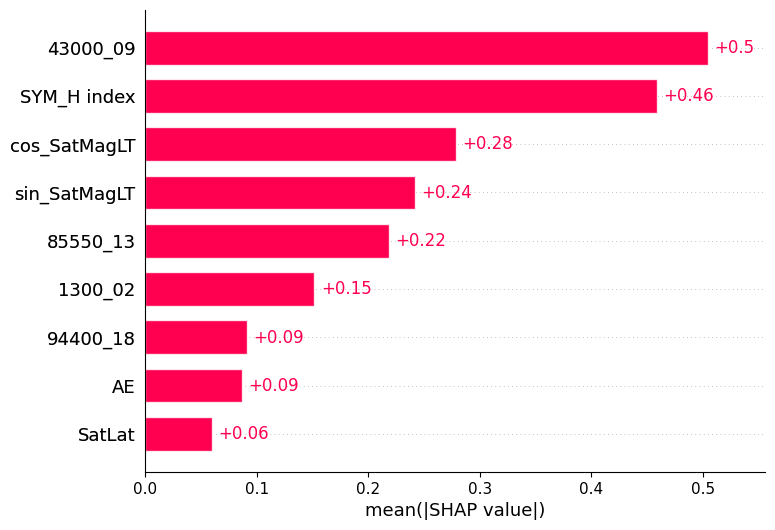

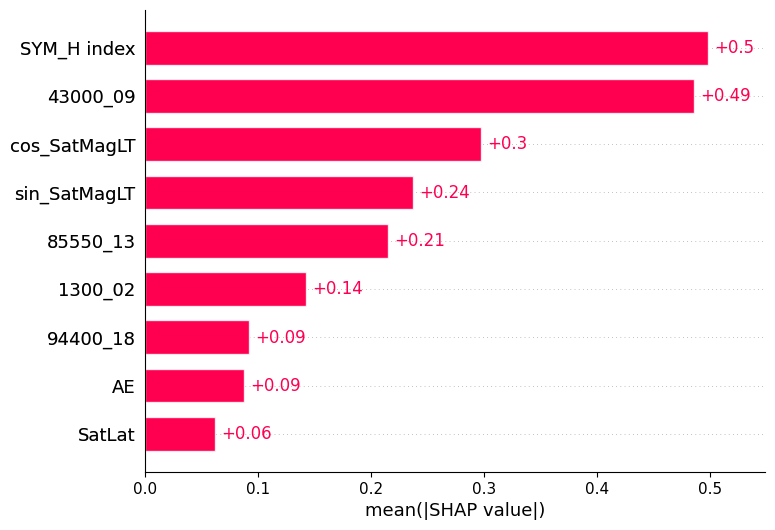

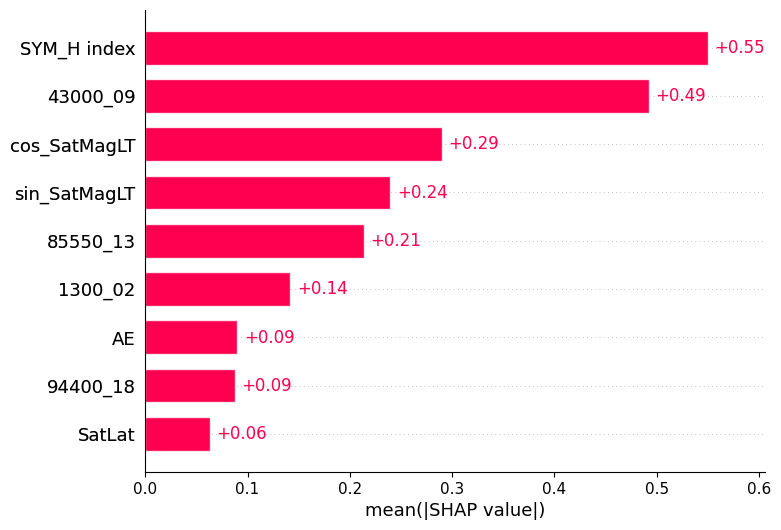

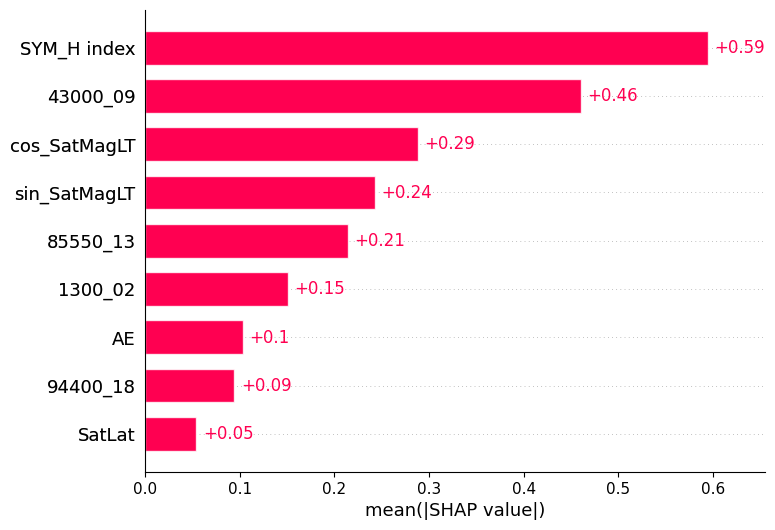

<Figure size 640x480 with 0 Axes>

In [36]:
for i,(shp, bin_sym) in enumerate(zip(bn_shap, sym_h_bins[:-1])):
    fts.plots.bar(shp)
    f = plt.gcf()
    #f.savefig(f"barSYMbin{bin_sym}.png", bbox_inches="tight")
    f.clf()

Then I get the SHAP values for 43 nm, cos(MLT), and SYM-H from each bin and plot them:

In [39]:
_fgeo_col_dict = {name: index for index, name in enumerate(fgeo_col)}
_fgeo_col_dict

{'1300_02': 0,
 '43000_09': 1,
 '85550_13': 2,
 '94400_18': 3,
 'SYM_H index': 4,
 'AE': 5,
 'SatLat': 6,
 'cos_SatMagLT': 7,
 'sin_SatMagLT': 8}

In [40]:
sym_h_bins

[-20, -25, -30, -35, -40, -45, -50, -55, -60, -65, -70, -75]

In [41]:
SHAP_sym_h = [np.abs(shp.values[:, _fgeo_col_dict['SYM_H index']]).mean() for shp in bn_shap]
SHAP_43 = [np.abs(shp.values[:, _fgeo_col_dict['43000_09']]).mean() for shp in bn_shap]
SHAP_cos = [np.abs(shp.values[:, _fgeo_col_dict['cos_SatMagLT']]).mean() for shp in bn_shap]

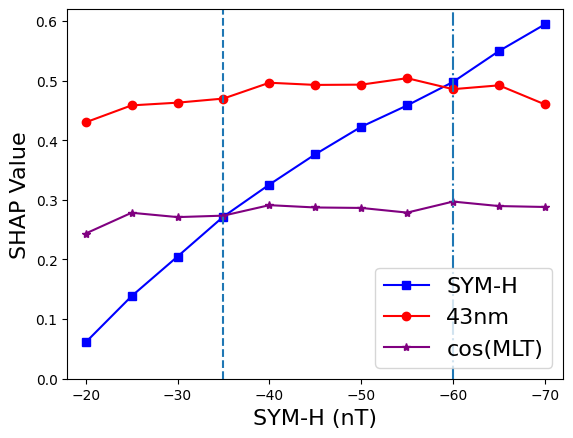

In [42]:
fig, ax = plt.subplots()
ax.plot(sym_h_bins[:-1], SHAP_sym_h, color='blue', marker='s', label="SYM-H")
ax.plot(sym_h_bins[:-1], SHAP_43, color='red', marker='o', label="43nm")
ax.plot(sym_h_bins[:-1], SHAP_cos, color='purple', marker='*', label="cos(MLT)")
ax.set_ylim(0.,0.62)
ax.set_xlim(-18,-72)
ax.set_xlabel("SYM-H (nT)", size=16)
ax.set_ylabel("SHAP Value", size=16)
ax.legend(loc="lower right", fontsize=16)
ax.axvline(-35, ls='--')
ax.axvline(-60, ls='-.')
#fig.savefig("Bin_SHAP_compare.png")

##### end

The next notebook, Part C, will feature the **Interaction Analysis** between features.